In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd
from lmfit import Model
%run dbs_functions.py

fs = 10
%matplotlib inline

/Users/au652733/opt/anaconda3/envs/myenv_x86/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### O2-calibration Fit (Stern-Volmer)

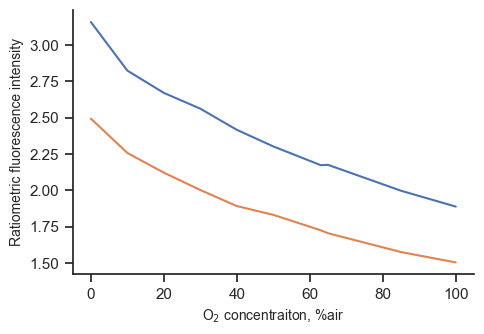

In [2]:
# Load data
file_o2 = 'Calibration_O2.xlsx'
df_all = pd.read_excel(file_o2, sheet_name=None)

# how to load and pre-process the dataFrame depends on how you created the Excel sheet
# ideally, have a list with the concentration, the average and standard error of the 
# ratiometric fluorescence intensity of the indicator
df_pt = df_all['19-05-2022'][['Concentration', 'Pt mean', 'Pt std']].loc[:32].dropna()
df_ind = df_pt.groupby('Concentration').mean()


# ----------------------------------------
# exploratory plot of calibration data 
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_xlabel('O$_2$ concentraiton, %air', fontsize=fs)
ax.set_ylabel('Ratiometric fluorescence intensity', fontsize=fs)
ax.plot(df_ind)
sns.despine()
plt.tight_layout()
plt.show()

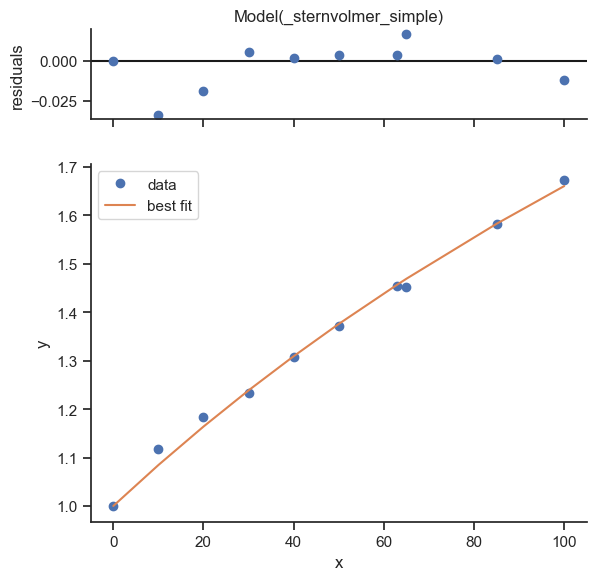

In [7]:
# set the fit model
gmod = Model(_sternvolmer_simple)

# fit the model for given data with initial fit parameters
params_sens = gmod.make_params(k=0.165, f=0.887)

resFit_o2 = gmod.fit(df_ind['Pt mean'].loc[0]/df_ind['Pt mean'].to_numpy(), params=params_sens, x=df_ind['Pt mean'].index,
                     nan_policy='omit')

# -------------------------------------------------
### [Display results]
# for the plot, have a closer look at the residuals if the data are 
# randomly scattered or if a trend in the data is visible.
resFit_o2.plot()
sns.despine()
plt.show()

# when looking at the result table, have a closer look at the reduced chi-square 
# the smaller the chi-parameter the better
resFit_o2

### pH-calibration Fit (Boltzmann)

In [95]:
# Load data
file_ph = 'Calibration_pH.xlsx'
df_all = pd.read_excel(file_ph, sheet_name=None)

# depending how the excel files was prepared, I would suggest
# sheet 1 to be named 'calibration'
# sheet 2 to be named 'sample'
df_calib = df_all['calibration']

# In the current file, two rows are descriptive header lines, however only the frist is identified as header.
# Hence, the function combines 2 rows as new header and returns the new DataFrame and the generated header
df, ls_head = combine_rows4header(l1=df_calib.columns,l2=df_calib.loc[0].to_numpy(), df=df_calib)
# The row that has been moved to the header must also be removed (here it is row 0)
df_calib = df.drop(0)
# Additionally, sey the first row as index
df_calib = df_calib.set_index(df_calib.columns[0]).sort_index()
df_calib

,chromoionophore XI R,chromoionophore B,chromoionophore ratio = R/B,"nan, nan",lipo-HPTS R,lipo-HPTS B,lipo-HPTS ratio = R/B
concentration pH,,,,,,,
2.033,57.231,133.46,0.428825,NaN,143.366,212.776,0.673788
4.94,63.634,156.169,0.407469,NaN,132.068,195.952,0.673981
6.43,81.15,192.452,0.421664,NaN,142.964,149.274,0.957729
6.942,68.284,122.663,0.55668,NaN,120.758,100.921,1.19656
7.526,89.602,117.798,0.760641,NaN,140.396,83.777,1.67583
8.02,127.94,117.811,1.085977,NaN,176.433,75.173,2.347026
11.331,388.36,195.892,1.982521,NaN,308.459,73.596,4.191247


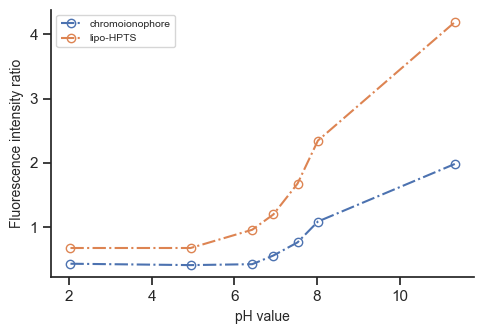

In [96]:
data_plot = df_calib.filter(like='ratio')

# figure plot
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_xlabel('pH value', fontsize=fs)
ax.set_ylabel('Fluorescence intensity ratio', fontsize=fs)
ax.plot(data_plot, ls='-.', marker='o', mfc='none')
ax.legend([i.split(' ')[0] for i in data_plot.columns], fontsize=fs*0.75)
sns.despine()
plt.tight_layout()
plt.show()

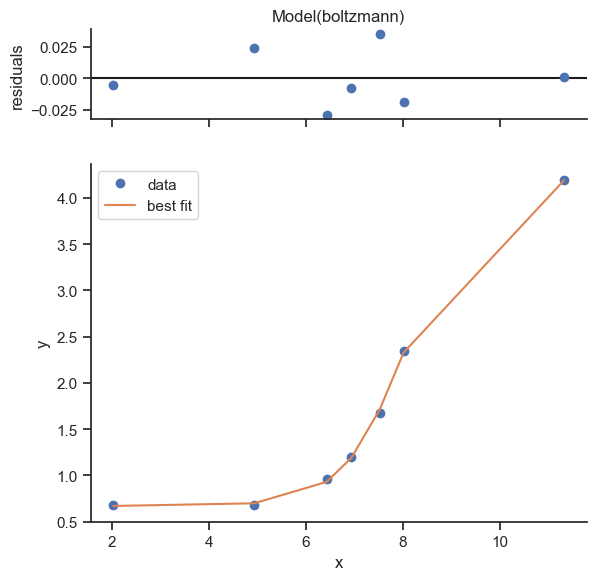

In [97]:
# model fit for one pH indicator
df_ind =  df_calib['lipo-HPTS ratio = R/B']

# create relevant parameters - the interpolation should only help identifying more accurate start parameters 
# the interpolated set must not be used for the fit!
xnew = list(df_ind.index) + list([8, 9, 10])
df_ind_inpl = pd.DataFrame(df_ind.copy())
for i in xnew:
    if i not in df_ind_inpl.index:
        df_ind_inpl.loc[i] = np.nan
df_ind_inpl = df_ind_inpl.sort_index().astype(float)      
df_ind_inpl = df_ind_inpl.interpolate(method='index')

# get the parameter for the boltzmann fit
V50 = df_ind_inpl.diff().dropna().idxmax().to_numpy()[0]
top, bottom = df_ind_inpl.max().values[0], df_ind_inpl.min().values[0]
slope = df_ind_inpl.diff().dropna().loc[V50].values[0]

# -------------------------------------------------
# set the fit model
para = bmod.make_params(top=top, bottom=bottom, V50=V50, slope=slope)

# fit the model for given data
resFit = bmod.fit(df_ind.to_numpy(), para, x=df_ind.index.to_numpy(), nan_policy='omit')

# -------------------------------------------------
### [Display results]
# for the plot, have a closer look at the residuals if the data are 
# randomly scattered or if a trend in the data is visible.
resFit.plot()
sns.despine()
plt.show()

# when looking at the result table, have a closer look at the reduced chi-square 
# the smaller the chi-parameter the better
resFit